# Libraries

In [35]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from os.path import exists
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import parallel_backend
from scipy.stats import randint, uniform
from textblob import TextBlob
import numpy as np



# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

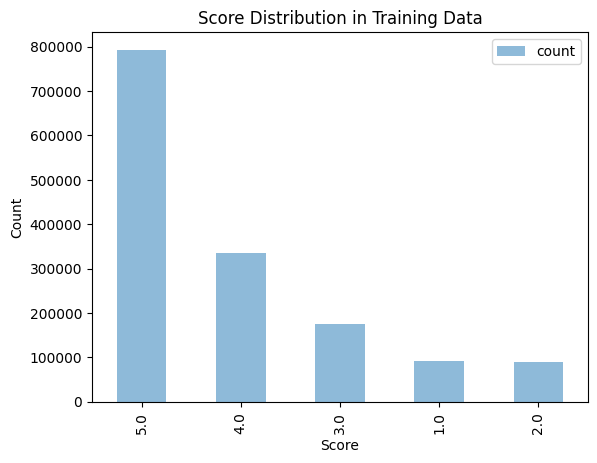


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [8]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)
print()

print(trainingSet.head())
print()
print(testingSet.head())
print()
print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Score Distribution in Training Data")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [9]:
def add_features_to(df):
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'].fillna(0, inplace=True)
    df['ReviewYear'] = pd.to_datetime(df['Time'], unit='s').dt.year
    df['ReviewMonth'] = pd.to_datetime(df['Time'], unit='s').dt.month
    df['TextLength'] = df['Text'].str.len().fillna(0)
    df['SummaryLength'] = df['Summary'].str.len().fillna(0)
    df['NumWordsText'] = df['Text'].str.split().str.len().fillna(0)
    df['NumWordsSummary'] = df['Summary'].str.split().str.len().fillna(0)
    df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)
    #df['AvgWordLengthText'] = df['Text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]) if x else 0)
    #df['AvgSentenceLengthText'] = df['Text'].apply(lambda x: len(str(x).split()) / (str(x).count('.') + 1) if x else 0)

    def calculate_sentiment(text, idx):
        sentiment_score = 0  # sentiment for missing or invalid data
        if isinstance(text, str): 
            sentiment_score = TextBlob(text).sentiment.polarity
        if idx % 100000 == 0:  
            print(f"Sentiment calculated for {idx} rows...")
        return sentiment_score
    
    df['TextPolarity'] = df.apply(lambda row: calculate_sentiment(row['Text'], row.name), axis=1)

    return df

if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    train = add_features_to(trainingSet)

    X_submission = pd.merge(train, testingSet, on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    X_train = train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)


/var/folders/12/sgrgj1zj27g2_6chndcqh8740000gn/T/ipykernel_16030/1266905743.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Helpfulness'].fillna(0, inplace=True)


Sentiment calculated for 0 rows...
Sentiment calculated for 100000 rows...
Sentiment calculated for 200000 rows...
Sentiment calculated for 300000 rows...
Sentiment calculated for 400000 rows...
Sentiment calculated for 500000 rows...
Sentiment calculated for 600000 rows...
Sentiment calculated for 700000 rows...
Sentiment calculated for 800000 rows...
Sentiment calculated for 900000 rows...
Sentiment calculated for 1000000 rows...
Sentiment calculated for 1100000 rows...
Sentiment calculated for 1200000 rows...
Sentiment calculated for 1300000 rows...
Sentiment calculated for 1400000 rows...
Sentiment calculated for 1500000 rows...
Sentiment calculated for 1600000 rows...


# Feature Selection

In [10]:
features = ['Helpfulness', 'ReviewYear', 'ReviewMonth', 'TextLength', 'SummaryLength', 'NumWordsText', 'NumWordsSummary', 'HelpfulnessRatio', 'TextPolarity'] 
X_train_select = X_train[features]
X_submission_select = X_submission[features]

# Sample + Split into training and testing set

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_select, X_train['Score'], test_size=0.25, random_state=43
)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Data Scaling for KNN and Logistic Regression Models

In [45]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_submission_select = scaler.transform(X_submission_select)


# Model Creation

In [48]:
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=43)
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
gb = GradientBoostingClassifier(random_state=43)
et = ExtraTreesClassifier(random_state=43)


# Model parameters
models = {
    'knn': (knn, {'n_neighbors': randint(5, 10), 'weights': ['uniform', 'distance']}),
    'rf': (rf, {'n_estimators': randint(50, 150), 'max_depth': randint(5, 12)}),
    'lr': (lr, {'C': uniform(0.1, 2)}),
    'gb': (gb, {'n_estimators': randint(10, 30), 'learning_rate': uniform(0.1, 0.3), 'max_depth': randint(2, 4), 'subsample': uniform(0.5, 0.5)}),
    'et': (et, {'n_estimators': randint(50, 120), 'max_depth': randint(5, 10)}),
}

best_score = 0
best_model = None
results = {}

for model_name, (model, params) in models.items():
    print(f"Starting {model_name} model tuning...")
    start_time = time.time()
    
    search = RandomizedSearchCV(model, params, n_iter=3, cv=3, random_state=43, n_jobs=-1) # n_jobs=-1 for parallel processing
    with parallel_backend('loky'):
        search.fit(X_train, Y_train)
    
    # Log results
    results[model_name] = search.best_score_
    elapsed_time = time.time() - start_time
    print(f"{model_name} best score: {search.best_score_} - Elapsed time: {elapsed_time:.2f} seconds")
    
    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_model = search.best_estimator_


print("\nSelected Model:", best_model)
print("Best Score:", best_score)

print("Training the selected best model on the full training data...")
best_model.fit(X_train, Y_train)
Y_test_predictions = best_model.predict(X_test)
print("Training complete.")


Starting gb model tuning...
gb best score: 0.5589005435343647 - Elapsed time: 203.52 seconds

Selected Model: GradientBoostingClassifier(learning_rate=0.26234866368502113, n_estimators=28,
                           random_state=43, subsample=0.6253052182307468)
Best Score: 0.5589005435343647
Training the selected best model on the full training data...
Training complete.


# Model Evaluation

Accuracy on testing set =  0.5429287760949653

Classification Report:
               precision    recall  f1-score   support

         1.0       0.62      0.19      0.29     22953
         2.0       0.25      0.02      0.03     22327
         3.0       0.16      0.01      0.02     44069
         4.0       0.19      0.00      0.00     84008
         5.0       0.55      0.99      0.70    197979

    accuracy                           0.54    371336
   macro avg       0.35      0.24      0.21    371336
weighted avg       0.41      0.54      0.40    371336



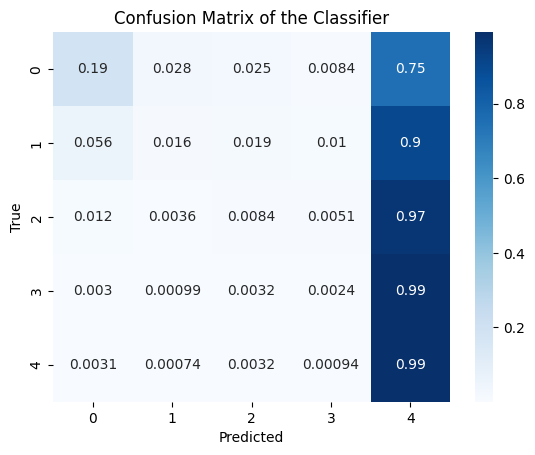

In [49]:
# Model Evaluation
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("\nClassification Report:\n", classification_report(Y_test, Y_test_predictions))

# Confusion Matrix Visualization
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix of the Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [18]:
# Submission File Creation
X_submission['Score'] = best_model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)
print("Submission file created as submission.csv")

Submission file created as submission.csv
